In [26]:
import pandas as pd

df_wine = pd.read_csv(
    'https://archive.ics.uci.edu/ml/'
    'machine-learning-databases/wine/wine.data',
    header=None
)

In [27]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=0
)

# standardize the features
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [28]:

import numpy as np

np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(
        np.mean(X_train_std[y_train==label], axis=0)
    )
    print(f'MV {label}: {mean_vecs[label - 1]}\n')

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



In [29]:
d = 13 # num of features
S_W = np.zeros((d, d))

for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter

print(
    'Within-class scatter matrix: '
    f'{S_W.shape[0]}x{S_W.shape[1]}'
)

Within-class scatter matrix: 13x13


In [30]:
print('Class label distrubtion:', np.bincount(y_train)[1:])

Class label distrubtion: [41 50 33]


In [31]:
d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter

print(
    'Scaled within-class scatter matrix: '
    f'{S_W.shape[0]}x{S_W.shape[1]}'
)

Scaled within-class scatter matrix: 13x13


In [32]:
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)

d = 13
S_B = np.zeros((d, d))

for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i+1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1) # make col vector
    S_B += n * (mean_vec - mean_overall).dot(
        (mean_vec - mean_overall).T
    )

print(
    'Between-class scatter matrix: '
    f'{S_W.shape[0]}x{S_W.shape[1]}'
)

Between-class scatter matrix: 13x13


In [33]:
eigen_vals, eigen_vecs = np.linalg.eig(
    np.linalg.inv(S_W).dot(S_B)
)

eigen_pairs = [
    (np.abs(eigen_vals[i]), eigen_vecs[:, i])
    for i in range(len(eigen_vals))
]
eigen_pairs = sorted(
    eigen_pairs,
    key=lambda k: k[0],
    reverse=True
)

print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

349.617808905994
172.7615221897938
3.939820615533238e-14
2.842170943040401e-14
1.7925907004994513e-14
1.6282428603934408e-14
1.6282428603934408e-14
1.1916379099674514e-14
1.1916379099674514e-14
8.08514340562765e-15
5.617170912153432e-15
5.617170912153432e-15
4.981875933861479e-15


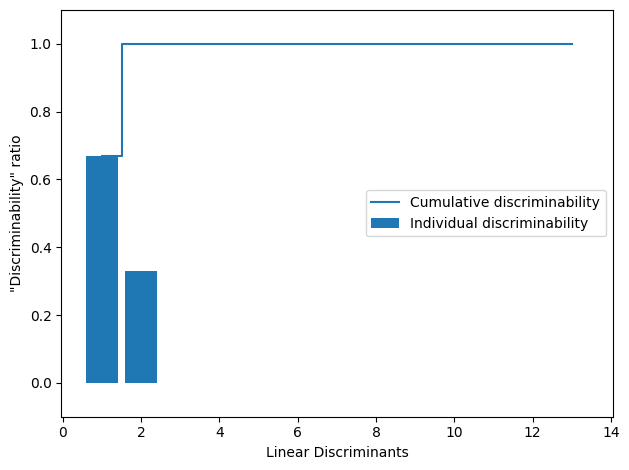

In [34]:
import matplotlib.pyplot as plt 

tot = sum(eigen_vals.real)
discr = [
    (i / tot) for i in sorted(eigen_vals.real, reverse=True)
]
cum_discr = np.cumsum(discr)

plt.bar(
    range(1, 14), 
    discr, 
    align='center',
    label='Individual discriminability'
)
plt.step(
    range(1, 14), 
    cum_discr, 
    where='mid',
    label='Cumulative discriminability'
)
plt.ylabel('"Discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [35]:
w = np.hstack((
    eigen_pairs[0][1][:, np.newaxis].real,
    eigen_pairs[1][1][:, np.newaxis].real,
))

print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


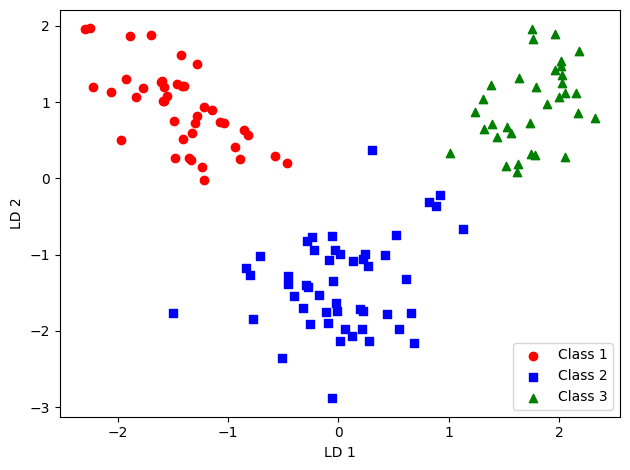

In [36]:
X_train_lda = X_train_std.dot(w)

colors = ['r', 'b', 'g']
markers = ['o', 's', '^']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(
        X_train_lda[y_train == l, 0],
        X_train_lda[y_train == l, 1] * (-1),
        c=c, label=f'Class {l}', marker=m
    )
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [38]:
# sklearn way
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

/home/mys1erious/UserFolder/venvs/ml-raschka/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


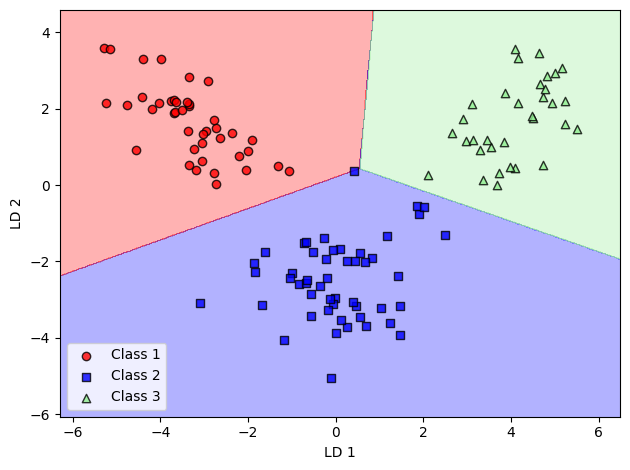

In [39]:
from utils import plot_decision_regions
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    multi_class='ovr',
    random_state=1,
    solver='lbfgs'
)
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

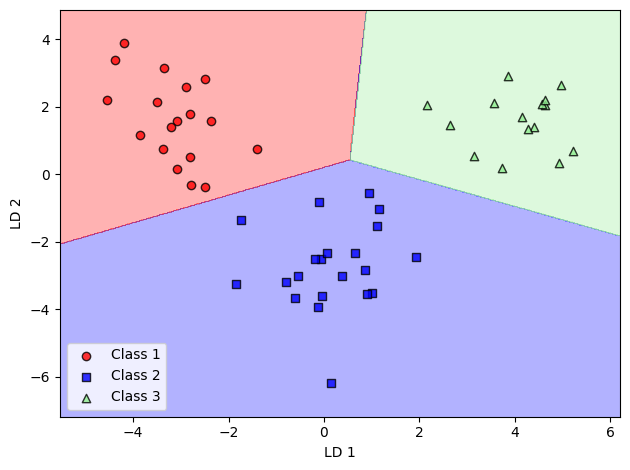

In [40]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()